In [1]:
using Pkg
Pkg.activate("..")
using Revise
using FUSE
using AD_TGLFNN
using AD_EPEDNN
using Plots; gr();

  Activating project at `~/Coding/julia/FUSE`
┌ Info: Precompiling FUSE [e64856f0-3bb8-4376-b4b7-c03396503992]
└ @ Base loading.jl:1423


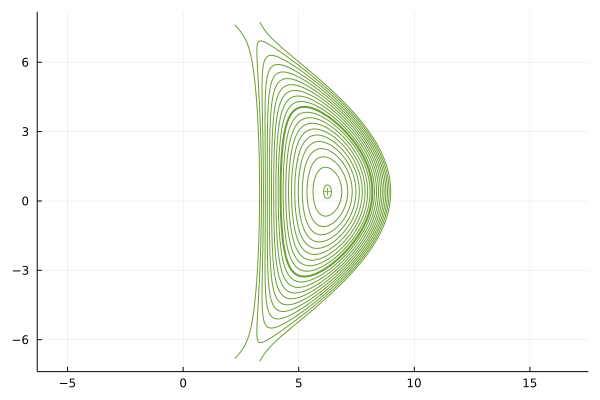

 * Status: success

 * Candidate solution
    Final objective value:     1.772844e-03

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-03

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    39
    f(x) calls:    77

  1.489107 seconds (22.98 M allocations: 377.289 MiB, 2.94% gc time)
(dd.equilibrium.time_slice[]).global_quantities.beta_tor = 0.028619042458169534
(dd.equilibrium.time_slice[]).global_quantities.beta_pol = 0.7535294742594427
(dd.equilibrium.time_slice[]).global_quantities.beta_normal = 2.0032631494189017
(dd.equilibrium.time_slice[]).global_quantities.ip = 1.5022237867302563e7
(dd.equilibrium.time_slice[]).global_quantities.li_3 = 0.3669943138476513


0.3669943138476513

In [17]:
if true
    ϵ = 0.32
    κ = 1.85
    δ = 0.485
    R0 = 6.2
    Z0 = 0.4
    B0 = 5.3
    ip = 15.E6
    βn = 2.0
    x_point = false#(5.0, -3.8)
    symmetric=true
    resolution = 129

    dd = IMAS.dd()
    eqt=resize!(dd.equilibrium.time_slice,-1.0)

    dd.global_time = 0.0
    FUSE.init(dd.equilibrium; B0, R0, Z0, ϵ, δ, κ, beta_n=βn, ip, x_point=x_point)
    
    eqactor = FUSE.SolovevEquilibriumActor(dd, symmetric=symmetric)
    @time FUSE.step(eqactor,verbose=true)
    FUSE.finalize(eqactor, resolution, (maximum([R0*(1-ϵ*2), 0.0]), R0*(1+ϵ*2)), (-R0*ϵ*κ*2, R0*ϵ*κ*2))

elseif false
    filename = joinpath(dirname(abspath(@__FILE__)), "..", "sample","CAT_eq_ods.json")
    dd = IMAS.json2imas(filename);
    @time IMAS.flux_surfaces(dd.equilibrium);
else
    filename = joinpath(dirname(abspath(@__FILE__)), "..", "sample","ITER_eq_ods.json")
    dd = IMAS.json2imas(filename);
    dd.equilibrium.time=[0.0]
    @time IMAS.flux_surfaces(dd.equilibrium);
end

display(plot(dd.equilibrium))
if true
    @show dd.equilibrium.time_slice[].global_quantities.beta_tor
    @show dd.equilibrium.time_slice[].global_quantities.beta_pol
    @show dd.equilibrium.time_slice[].global_quantities.beta_normal
    @show dd.equilibrium.time_slice[].global_quantities.ip;
    @show dd.equilibrium.time_slice[].global_quantities.li_3;
end

In [18]:
FUSE.init(dd.core_profiles, dd.equilibrium, dd.summary; ne_ped=1e20, ne_peaking=1.5, Te_ped=500, Te_peaking=3, w_ped=0.08, zeff=2, Paux=2e6, n_points=101)
FUSE.init(dd.core_sources, dd.equilibrium; Paux_e=5e6, Paux_i=5e6);

  0.024156 seconds (195.11 k allocations: 13.986 MiB)


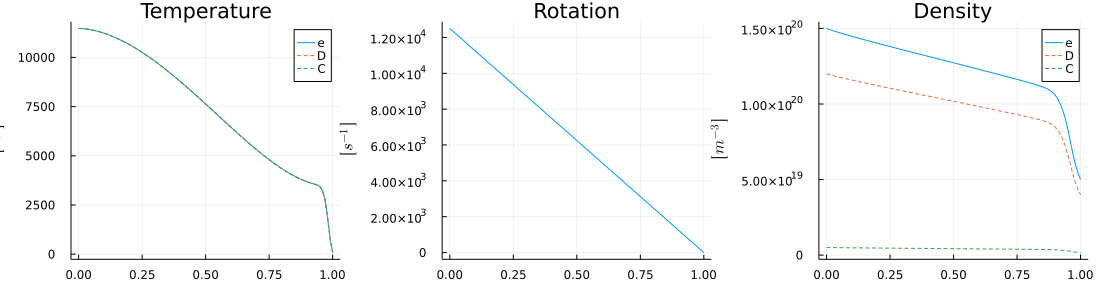

In [19]:
tauennactor = FUSE.TaueNNactor(dd)
@time FUSE.step(tauennactor)

plot(dd.core_profiles)

In [20]:
# currently broken
if false

    using NNlib
    using Flux
    using Dates
    using AD_EPEDNN
    using AD_TGLFNN


    # run tauenn from standalone
    inputs = TauennInputs()
    inputs.q0= 1.2
    inputs.mixing = "dc"
    inputs.ngrid = 101
    inputs.delta = 0.45
    inputs.iterations=100
    inputs.rho_fluxmatch=0.6
    inputs.error=0.001
    #display(inputs)
    @time outputs = tau_enn(inputs; verbose=true);
    display(outputs)

    plot(outputs.ods.core_profiles.profiles_1d[1].electrons.temperature, label="$(inputs.Paux)MW")
end